In [1]:
cd /workspace/fast-influence-functions/

/workspace/fast-influence-functions


In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [3]:
import torch
import numpy as np
from glob import glob
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
from sklearn.metrics import recall_score
from experiments import constants
from experiments import misc_utils
from influence_utils import faiss_utils
from experiments.visualization import get_recall_plot

faiss_index = faiss_utils.FAISSIndex(768, "Flat")
faiss_index.load(constants.MNLI_FAISS_INDEX_PATH)
# full_influences_collections\ = torch.load("/export/home/hguo/Experiments/20200818/MNLI-influences-full.pt")
full_influences_collections = [
    torch.load(file_name)
    for file_name in tqdm(glob(f"/export/home/hguo/Experiments/20200922/KNN-recall.only-*.50.*.pth.g0301.ll.unc.edu"))]

len(faiss_index)

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.
100%|██████████| 100/100 [00:15<00:00,  6.54it/s]


392702

In [4]:
tokenizer, model = misc_utils.create_tokenizer_and_model(
    constants.MNLI_MODEL_PATH)

(mnli_train_dataset,
 mnli_eval_dataset) = misc_utils.create_datasets(
    task_name="mnli",
    tokenizer=tokenizer)

eval_instance_data_loader = misc_utils.get_dataloader(
    dataset=mnli_eval_dataset,
    batch_size=1,
    random=False)

Params Trainable: 14768643
	bert.encoder.layer.10.attention.self.query.weight
	bert.encoder.layer.10.attention.self.query.bias
	bert.encoder.layer.10.attention.self.key.weight
	bert.encoder.layer.10.attention.self.key.bias
	bert.encoder.layer.10.attention.self.value.weight
	bert.encoder.layer.10.attention.self.value.bias
	bert.encoder.layer.10.attention.output.dense.weight
	bert.encoder.layer.10.attention.output.dense.bias
	bert.encoder.layer.10.attention.output.LayerNorm.weight
	bert.encoder.layer.10.attention.output.LayerNorm.bias
	bert.encoder.layer.10.intermediate.dense.weight
	bert.encoder.layer.10.intermediate.dense.bias
	bert.encoder.layer.10.output.dense.weight
	bert.encoder.layer.10.output.dense.bias
	bert.encoder.layer.10.output.LayerNorm.weight
	bert.encoder.layer.10.output.LayerNorm.bias
	bert.encoder.layer.11.attention.self.query.weight
	bert.encoder.layer.11.attention.self.query.bias
	bert.encoder.layer.11.attention.self.key.weight
	bert.encoder.layer.11.attention.self.ke

In [5]:
from experiments.visualization import *
def get_recall_plot(model, example, faiss_index, full_influences_dict):
    # plt.rcParams["figure.figsize"] = [20, 5]
    recall_num_neighbors = [10, 100, 1000]
    num_neighbors = [10, 100, 1000, 5000, 10000, 50000, 100000, 500000]
    names = ["Most Helpful",
             "Most Harmful",
             "Most Influencetial",
             "Least Influential"]

    features = misc_utils.compute_BERT_CLS_feature(model, **example)
    features = features.cpu().detach().numpy()
    if list(full_influences_dict.keys()) != list(range(len(full_influences_dict))):
        raise ValueError

    full_influences = []
    for key in sorted(full_influences_dict):
        full_influences.append(full_influences_dict[key])

    sorted_indices_small_to_large = np.argsort(full_influences)
    sorted_indices_large_to_small = np.argsort(full_influences)[::-1]
    sorted_indices_abs_large_to_small = np.argsort(np.abs(full_influences))[::-1]
    sorted_indices_abs_small_to_large = np.argsort(np.abs(full_influences))

    fig, axes = plt.subplots(1, 4, sharex=True, sharey=True)
    recalls_collections = {}
    for i, (name, sorted_indices) in enumerate(zip(
            names,
            [sorted_indices_small_to_large,
             sorted_indices_large_to_small,
             sorted_indices_abs_large_to_small,
             sorted_indices_abs_small_to_large])):

        recalls_collection = []
        for recall_k in tqdm(recall_num_neighbors):
            recalls = []
            influential = sorted_indices[:recall_k]
            influential_set = set(influential.tolist())
            for k in num_neighbors:
                distances, indices = faiss_index.search(k=k, queries=features)
                indices_set = set(indices.squeeze(axis=0).tolist())
                recall = len(influential_set & indices_set) / len(influential_set)
                recalls.append(recall)

            recalls_collection.append(recalls)
            axes[i].plot(num_neighbors, recalls,
                         linestyle="--", marker="o",
                         label=f"recall@{recall_k}")

        axes[i].legend()
        axes[i].set_title(name)
        axes[i].set_xscale("log")
        axes[i].set_ylabel("Recall")
        axes[i].set_xlabel("Number of Nearest Neighbors")
        recalls_collections[name] = recalls_collection

    return recalls_collections

In [6]:
index_to_influences_collections = dict(
    (collections["test_index"], collections)
    for collections in full_influences_collections)

len(full_influences_collections), len(index_to_influences_collections.keys())

(100, 100)

In [1]:
# %%time
# correct_recalls_collections = []
# incorrect_recalls_collections = []
# for i, example in enumerate(eval_instance_data_loader):
#     if i not in index_to_influences_collections.keys():
#         continue

#     full_influences_dict = index_to_influences_collections[i]["influences"]
#     recalls_collection = get_recall_plot(model, example, faiss_index, full_influences_dict)
    
#     print(f"#{i}/{len(index_to_influences_collections)} Finished: "
#           f"{len(correct_recalls_collections)}, {len(incorrect_recalls_collections)}")
#     if bool(index_to_influences_collections[i]["correct"]) is True:
#         correct_recalls_collections.append(recalls_collection)
#     else:
#         incorrect_recalls_collections.append(recalls_collection)

In [8]:
i, len(full_influences_collections), len(correct_recalls_collections), len(incorrect_recalls_collections)

(9814, 100, 50, 50)

In [9]:
print(f"#{i}/{len(index_to_influences_collections)} Finished: "
      f"{len(correct_recalls_collections)}, {len(incorrect_recalls_collections)}")

#9814/100 Finished: 50, 50


In [37]:
incorrect_recalls_collections[0].keys() == correct_recalls_collections[0].keys()

True

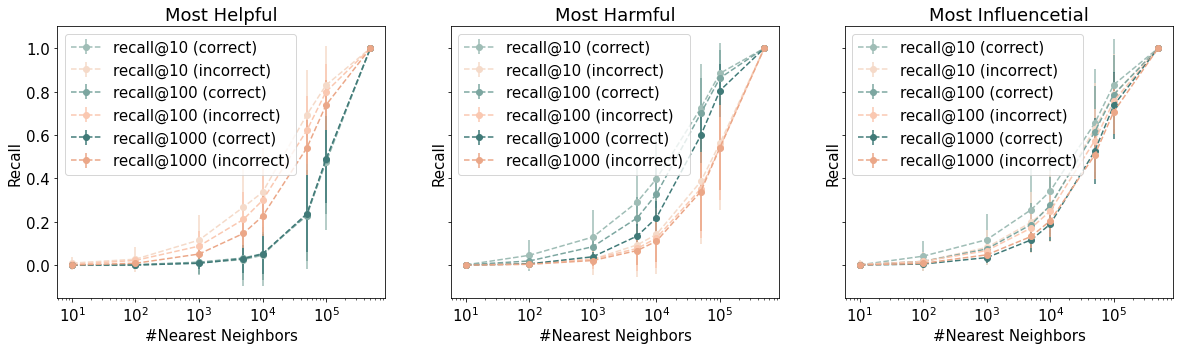

In [49]:
plt.rcParams["figure.figsize"] = [20, 5]
plt.rcParams.update({"font.size": 15})

recall_num_neighbors = [10, 100, 1000]
num_neighbors = [10, 100, 1000, 5000, 10000, 50000, 100000, 500000]
fig, axes = plt.subplots(1, 3, sharex=True, sharey=True)
for name_index, name in enumerate(correct_recalls_collections[0].keys()):
    if name == "Least Influential":
        continue

    for k_index, recall_k in enumerate(recall_num_neighbors):
        correct_recalls_stacked = np.stack(
            [recalls[name][k_index]
             for recalls in correct_recalls_collections],
            axis=0)
        incorrect_recalls_stacked = np.stack(
            [recalls[name][k_index]
             for recalls in incorrect_recalls_collections],
            axis=0)

        for recalls_type, recalls_stacked in zip(
                ["correct", "incorrect"],
                [correct_recalls_stacked,
                 incorrect_recalls_stacked]):
            recalls_mean = recalls_stacked.mean(axis=0)
            recalls_std = recalls_stacked.std(axis=0)
            axes[name_index].errorbar(
                num_neighbors,
                recalls_mean,
                yerr=recalls_std,
                linestyle="--", marker="o",
                label=f"recall@{recall_k} ({recalls_type})",
                color={
                    (10, "correct"): "#9FBDB6",
                    (100, "correct"): "#7CA6A0",
                    (1000, "correct"): "#407A78",
                    (10, "incorrect"): "#F5DAC9",
                    (100, "incorrect"): "#FAC8B1",
                    (1000, "incorrect"): "#EBA788",
                }[(recall_k, recalls_type)])

    axes[name_index].legend()
    axes[name_index].set_title(name)
    axes[name_index].set_xscale("log")
    axes[name_index].set_ylabel("Recall")
    axes[name_index].set_xlabel("#Nearest Neighbors")
fig.savefig("./20201014-KNN-recalls-combined.pdf")

In [47]:
# plt.rcParams["figure.figsize"] = [20, 5]
# recall_num_neighbors = [10, 100, 1000]
# num_neighbors = [10, 100, 1000, 5000, 10000, 50000, 100000, 500000]
# fig, axes = plt.subplots(1, 4, sharex=True, sharey=True)
# for name_index, name in enumerate(incorrect_recalls_collections[0].keys()):
#     for k_index, recall_k in enumerate(recall_num_neighbors):
#         recalls_stacked = np.stack([recalls[name][k_index] for recalls in incorrect_recalls_collections], axis=0)
#         recalls_mean = recalls_stacked.mean(axis=0)
#         recalls_std = recalls_stacked.std(axis=0)
#         axes[name_index].errorbar(
#             num_neighbors,
#             recalls_mean,
#             yerr=recalls_std,
#             linestyle="--", marker="o",
#             label=f"recall@{recall_k}",
#             color={
#                 10: "#8DAAA6",
#                 100: "#E9AE8C",
#                 1000: "#FF9376",
#             }[recall_k])

#     axes[name_index].legend()
#     axes[name_index].set_title(name)
#     axes[name_index].set_xscale("log")
#     axes[name_index].set_ylabel("Recall")
#     axes[name_index].set_xlabel("Number of Nearest Neighbors")
# # fig.savefig("./20200923-KNN-recall-incorrect.pdf")

In [12]:
# fig.savefig("./20200819-knn-recalls.pdf")

In [222]:
N = int(392701 + 1)
k = int(5 * 10**3)
m = 10

In [223]:
from scipy.special import comb
sum([i * comb(m, i, exact=True) * (k/N)**i * (1 - k/N)**(m-i) for i in range(m + 1)]) / m * 100

1.273230082861814

In [201]:
recalls = []
for _ in trange(500):
    sampled_data = np.random.choice(N, size=k, replace=False)
    top_m = np.random.choice(N, size=m, replace=False)
    recall = len(set(top_m) & set(sampled_data)) / len(set(top_m))
    recalls.append(recall)

100%|██████████| 500/500 [00:11<00:00, 42.78it/s]


In [202]:
np.mean(recalls)

0.016615384615384615

In [40]:
(1 - k/N)**(m-1)

0.3874204890000001